In [1]:
import numpy as np
import time
import cv2 as cv
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
configPath = '__models/11_YOLOv3/yolov3.cfg'
weightsPath = '__models/11_YOLOv3/yolov3.weights'

net = cv.dnn.readNetFromDarknet(configPath, weightsPath)

In [3]:
times = []
bboxes = []

base_path = "./dataset/dataset_augmented/test/images"
images = os.listdir(base_path)

for idx, img in enumerate(images):
    image = cv.imread(os.path.join(base_path, img))

    (H, W) = image.shape[:2]

    # Output Layers
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv.dnn.blobFromImage(
        image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    start = time.time()
    net_output = net.forward(ln)
    end = time.time()

    times.append(end - start)
    print("[INFO] {:.6f} for image".format(
        end - start) + f" {idx + 1}/{len(images)}")

    boxes = []
    confidences = []
    # classIDs = []

    for output in net_output:
        for detection in output:
            scores = detection[5:]

            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > 0.5:
                # Scale bbox to original scale
                # YOLO returns center (x, y) and width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # Top left corner
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, x + int(width), y + int(height)])
                confidences.append(float(confidence))
                # classIDs.append(classID)

    # NMS
    idxs = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)
    boxes = [boxes[i] for i in idxs]

    bboxes.append(boxes)


[INFO] 0.198500 for image 1/790
[INFO] 0.096001 for image 2/790
[INFO] 0.089500 for image 3/790
[INFO] 0.090000 for image 4/790
[INFO] 0.088501 for image 5/790
[INFO] 0.092000 for image 6/790
[INFO] 0.092500 for image 7/790
[INFO] 0.090001 for image 8/790
[INFO] 0.088501 for image 9/790
[INFO] 0.088500 for image 10/790
[INFO] 0.090001 for image 11/790
[INFO] 0.089502 for image 12/790
[INFO] 0.089501 for image 13/790
[INFO] 0.089000 for image 14/790
[INFO] 0.089000 for image 15/790
[INFO] 0.089000 for image 16/790
[INFO] 0.090500 for image 17/790
[INFO] 0.094001 for image 18/790
[INFO] 0.092501 for image 19/790
[INFO] 0.090001 for image 20/790
[INFO] 0.096501 for image 21/790
[INFO] 0.095003 for image 22/790
[INFO] 0.093001 for image 23/790
[INFO] 0.088501 for image 24/790
[INFO] 0.090501 for image 25/790
[INFO] 0.089001 for image 26/790
[INFO] 0.090001 for image 27/790
[INFO] 0.089000 for image 28/790
[INFO] 0.093001 for image 29/790
[INFO] 0.092499 for image 30/790
[INFO] 0.090500 for

In [4]:
import pandas as pd
import numpy as np

p_images = []
p_times = []
p_x1 = []
p_y1 = []
p_x2 = []
p_y2 = []

for p_image, p_time, p_bbox in zip(images, times, bboxes):

    # No Bbox
    if len(p_bbox) == 0:
        p_images.append(p_image)
        p_times.append(p_time)

        p_x1.append(np.NAN)
        p_y1.append(np.NAN)
        p_x2.append(np.NAN)
        p_y2.append(np.NAN)

    # Bbox
    for box in p_bbox:
        # TODO :: Adjust format (x1, y1, ?, ?)
        p_images.append(p_image)
        p_times.append(p_time)

        p_x1.append(box[0])
        p_y1.append(box[1])
        p_x2.append(box[2])
        p_y2.append(box[3])

df = pd.DataFrame(list(zip(p_images, p_times, p_x1, p_y1, p_x2, p_y2)), columns=[
                  "Image", "Time", "X1", "Y1", "X2", "Y2"])
df

,Image,Time,X1,Y1,X2,Y2
0,1001_jpg.rf.b7c44a27e79dbc4de661327ba01c1edd.jpg,0.198500,224,148,455,559
1,1005_jpg.rf.bb3f3203348f9e88224f7467ef52843c.jpg,0.096001,239,178,490,435
2,1005_jpg.rf.bb3f3203348f9e88224f7467ef52843c.jpg,0.096001,140,116,193,186
3,1014_jpg.rf.c539a1eadeef2d13f1bf7d0f7b5c254c.jpg,0.089500,175,129,328,388
4,1061_jpg.rf.44dd02d8bd98efc8deac4f6fbc60ef99.jpg,0.090000,336,143,405,276
...,...,...,...,...,...,...
1259,986_jpg.rf.6f8ff4f13b76e435399fe4d604c285b3.jpg,0.090501,255,140,468,521
1260,987_jpg.rf.dff0e90c55a7621864aee639fd482d98.jpg,0.088500,234,144,288,259
1261,987_jpg.rf.dff0e90c55a7621864aee639fd482d98.jpg,0.088500,325,102,402,205
1262,98_jpg.rf.c929bd3c5be065cfdc29dfe04ff72d87.jpg,0.092999,271,194,361,370


110_jpg.rf.b9fdbaf5c107a2c0f47e4221f1110b75.jpg
435 96 515 261
175 80 249 228


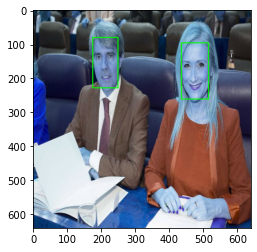

In [7]:
image_names = np.unique(df.Image)
current_entry = image_names[6] # "1_jpg.rf.e3e0a48dd72710db0188e9c100a49f5f.jpg" # 
print(current_entry)

current_df = df[df['Image'] == current_entry]

# Read image from your local file system
testImage = cv.imread(os.path.join(base_path, current_entry))

for df_idx, row in current_df.iterrows():
    if np.isnan(row['X1']):
        continue

    x1 = int(row['X1'])
    y1 = int(row['Y1'])
    x2 = int(row['X2'])
    y2 = int(row['Y2'])

    print(x1, y1, x2, y2)

    cv.rectangle(
        testImage,
        (x1, y1),
        (x2, y2),
        (0, 255, 0),
        2
    )

plt.figure(figsize=(4, 4))
plt.imshow(testImage)
plt.show()


In [8]:
model_name = "YoloV3"

folder_path = f"./test_results/{model_name}"
os.mkdir(folder_path)

results_path = f"./test_results/{model_name}.xlsx"


df.to_excel(results_path, index=False)